<h1 style="font-size: 42px;">SAR tutorial</h1>

In this notebook, we introduce synergistic action representations (SAR) and demonstrate how to use these representations to facilitate the training of high-dimensional continuous control policies within MyoSuite.

The primary purpose of this notebook is to equip the user to train with SAR for their own task specification(s) both within and beyond the musculoskeletal control paradigm.

<br>
<br>

<h1 style="font-size: 28px;">Contents of this notebook</h1>

<ul style="line-height: 2; font-size: 16px;">
  <li><b>Imports and utilities</b>: set up tutorial with relevant imports and starter functions.
  </li>
  <li><b>Walkthrough of SAR core functions</b>: steps through and defines each of the four basic functions of the SAR method.
  </li>
  <li><b>Example 1: SAR x physiological locomotion</b>: end-to-end training example using the SAR method to learn forward locomotion on a diverse set of terrains.
  </li>
  <li><b>Example 2: SAR x physiological dexterity</b>: end-to-end training example using the SAR method to learn multiobject manipulation of parametric geometries.
  </li>
</ul>
<br>
<br>


# Imports and utilities

First, we import our required and helper functions from `SAR_tutorial_utils.py`. If you encounter import errors, it is recommended to `pip install` any imports that are missing in your particular environment by uncommenting out the appropriate lines below.

In [1]:
# !pip install stable-baselines3
# !pip install joblib
# !pip install scikit-learn
# !pip install tqdm
# !pip install matplotlib
# !pip install gymnasium

In [2]:
# imports for SAR
from SAR_tutorial_utils import *
import torch
torch.cuda.is_available()


MyoSuite:> Registering Myo Envs


True

# SAR core functions

<div style="display: flex; align-items: flex-start;">
    <div style="flex: 1;">
         Next, implement for SAR step by step. The framework follows the basic structure displayed below. Accordingly, we will implement functions that do each of the following:
        <br>
        <br>
        <ol>
            <li>Train a play phase policy.</li>
            <li>Roll out play phase policy to capture muscle activations over time</li>
            <li>Compute SAR from this activation dataset</li>
            <li>Use computed SAR to train on target task</li>
        </ol>
        <br>
        As we implement each of the above, we will also go into more detail about best practices for that step.
        <br>
    </div>
</div>

<div style="width:100%;">
    <img src="./SAR_images/framework.png" alt="SAR framework" style="width:1200px; display:block; margin-left:auto; margin-right:auto;"/>
</div>

### Step 1: Train a play phase policy

When selecting a play phase environment, it is advised to select a task that is both (a) simple enough that vanilla RL will be able to make reasonable progress on the task, and (b) sufficiently similar to the target task such that a synergistic representation learned from this simpler task will actually be informative for the target behavior. For example, in our manipulation pipeline, the play phase is a reorientation task composed of a small number of geometries, while the target reorientation task is composed of a much larger set of geometries. It is helpful to think of the play phase as a kind of curriculum learning that 'eases' the agent into learning useful representations for the target task.

`train()` enables the simple training of a policy using the stable-baselines3 implementation of SAC on a desired environment.

In [ ]:
def train(env_name, policy_name, timesteps, seed):
    """
    Trains a policy using sb3 implementation of SAC.
    
    env_name: str; name of gym env.
    policy_name: str; choose unique identifier of this policy
    timesteps: int; how long you want to train your policy for
    seed: str (not int); relevant if you want to train multiple policies with the same params
    """
    env = gym.make(env_name)
    env = Monitor(env)
    env = DummyVecEnv([lambda: env])
    env = VecNormalize(env, norm_obs=True, norm_reward=False, clip_obs=10.)
    
    net_shape = [400, 300]
    policy_kwargs = dict(net_arch=dict(pi=net_shape, qf=net_shape))
    
    model = SAC('MlpPolicy', env, learning_rate=linear_schedule(.001), buffer_size=int(3e5),
            learning_starts=1000, batch_size=256, tau=.02, gamma=.98, train_freq=(1, "episode"),
            gradient_steps=-1,policy_kwargs=policy_kwargs, verbose=1)
    
    succ_callback = SaveSuccesses(check_freq=1, env_name=env_name+'_'+seed, 
                             log_dir=f'{policy_name}_successes_{env_name}_{seed}')
    
    model.set_logger(configure(f'{policy_name}_results_{env_name}_{seed}'))
    model.learn(total_timesteps=int(timesteps), callback=succ_callback, log_interval=4)
    model.save(f"{policy_name}_model_{env_name}_{seed}")
    env.save(f'{policy_name}_env_{env_name}_{seed}')

### Step 2: Roll out play phase policy to capture muscle activations over time

`get_activations()` extracts muscle activation data at each timestep of the trained play phase policy's rollouts. In this implementation, `get_activations()` captures muscle activations from a given rollout if the rewards from that rollout fall above a certain threshold, computed as a percentile from a set of preview rollouts. 

Here, we set the number of sample episodes to 2000 and the reward percentile cutoff at 80%, though these should be considered hyperparameters that may require finetuning for a specific use case.

In [4]:
def get_activations(name, env_name, seed, episodes=2000, percentile=80):
    """
    Returns muscle activation data from N runs of a trained policy.

    name: str; policy name (see train())
    env_name: str; name of the gym environment
    seed: str; seed of the trained policy
    episodes: int; optional; how many rollouts?
    percentile: int; optional; percentile to set the reward threshold for considering an episode as successful
    """
    with gym.make(env_name) as env:
        env.reset()

        model = SAC.load(f'{name}_model_{env_name}_{seed}')
        vec = VecNormalize.load(f'{name}_env_{env_name}_{seed}', DummyVecEnv([lambda: env]))

        # Calculate the reward threshold from 100 preview episodes
        preview_rewards = []
        for _ in range(100):
            env.reset()
            rewards = 0
            done = False
            while not done:
                o = env.get_obs()
                o = vec.normalize_obs(o)
                a, __ = model.predict(o, deterministic=False)
                next_o, r, done, *_, info = env.step(a)
                rewards += r
            preview_rewards.append(rewards)
        reward_threshold = np.percentile(preview_rewards, percentile)

        # Run the main episode loop
        solved_acts = []
        for _ in tqdm(range(episodes)):
            env.reset()
            rewards, acts = 0, []
            done = False

            while not done:
                o = env.get_obs()
                o = vec.normalize_obs(o)
                a, __ = model.predict(o, deterministic=False)
                next_o, r, done, *_, info = env.step(a)
                acts.append(env.sim.data.act.copy())
                rewards += r

            if rewards > reward_threshold:
                solved_acts.extend(acts)

    return np.array(solved_acts)

### Step 3: Compute SAR from the activation dataset

We use linear representations (i.e., PCA, ICA, normalization) to approximate SAR. These representations are based directly on the motor neuroscience literature of representing muscle synergies (c.f., [Tresch et al, 2006](https://journals.physiology.org/doi/epdf/10.1152/jn.00222.2005)). Such representations also have the advantages of being highly interpretable and efficient for use as control signals. We also found in practice that nonlinear representations (such as VAE decoder networks) did not lead to strong performance are were far less efficient for training.

Before computing SAR, we first seek to understand how informative each individual muscle synergy is for explaining the initial muscle activation dataset. `find_synergies` returns a dictionary (and optionally, a plot) that shows variance accounted for (VAF) by N synergies from the original muscle activation data. In general, we find that using a number of synergies where VAF > 80% leads to good performance, though this value should be treated as a hyperparameter.

In [5]:
def find_synergies(acts, plot=True):
    """
    Computed % variance explained in the original muscle activation data with N synergies.
    
    acts: np.array; rollout data containing the muscle activations
    plot: bool; whether to plot the result
    """
    syn_dict = {}
    for i in range(acts.shape[1]):
        pca = PCA(n_components=i+1)me
        _ = pca.fit_transform(acts)
        syn_dict[i+1] =  round(sum(pca.explained_variance_ratio_), 4)
        
    if plot:
        plt.plot(list(syn_dict.keys()), list(syn_dict.values()))
        plt.title('VAF by N synergies')
        plt.xlabel('# synergies')
        plt.ylabel('VAF')
        plt.grid()
        plt.show()
    return syn_dict

Once the number of synergies to use is determined (above), `compute_SAR()` will take the activation data as input and yield the synergistic action representation (SAR) in the form of ICA, PCA, and normalizer objects.

In [6]:
def compute_SAR(acts, n_syn, save=False):
    """
    Takes activation data and desired n_comp as input and returns/optionally saves the ICA, PCA, and Scaler objects
    
    acts: np.array; rollout data containing the muscle activations
    n_comp: int; number of synergies to use
    """
    pca = PCA(n_components=n_syn)
    pca_act = pca.fit_transform(acts)
    
    ica = FastICA()
    pcaica_act = ica.fit_transform(pca_act)
    
    normalizer = MinMaxScaler((-1, 1))    
    normalizer.fit(pcaica_act)
    
    if save:
        joblib.dump(ica, 'ica_demo.pkl') 
        joblib.dump(pca, 'pca_demo.pkl')
        joblib.dump(normalizer, 'scaler_demo.pkl')
    
    return ica, pca, normalizer

### Step 4: Use computed SAR to train on target task

In order to train with SAR, we initialize a `SynNoSynWrapper`, which implements the policy architecture presented below. 

The policy takes as input $o_t$ and outputs an $O+N$-dimensional action vector, $a_{t}^{O+N}$, where $O$ is the dimensionality of the original action manifold and $N$ is the dimensionality of the synergistic manifold. The first $N$ synergistic actions are passed through $SAR(a_{t}^{N})=a_{t}^{SAR}$ to recover the synergistic muscle activations. The subsequent $O$ task-specific activations are mixed with the task-general activations using a linear blend $\varphi$ to recover the final action $a_t^*$ that steps the environment forward. Note that for the locomotion experiments presented next, it was actually found that purely relying on the synergistic, task-general pathway ($\varphi=1$) was sufficient for learning robust locomotion (see end-to-end example later in the notebook).

<div style="width:100%;">
    <img src="./SAR_images/pol_arch.png" alt="Policy Architecture" style="width:850px; display:block; margin-left:auto; margin-right:auto;"/>
</div>

In [7]:
class SynNoSynWrapper(gym.ActionWrapper):
    """
    gym.ActionWrapper that reformulates the action space as the combination of a task-general synergy space and a
    task-specific orginal space, and uses this mix to step the environment in the original action space.
    """
    def __init__(self, env, ica, pca, scaler, phi):
        super().__init__(env)
        self.ica = ica
        self.pca = pca
        self.scaler = scaler
        self.weight = phi
        
        self.syn_act_space = self.pca.components_.shape[0]
        self.no_syn_act_space = env.action_space.shape[0]
        self.full_act_space = self.syn_act_space + self.no_syn_act_space
        
        self.action_space = gym.spaces.Box(low=-1., high=1., shape=(self.full_act_space,),dtype=np.float32)
    def action(self, act):
        syn_action = act[:self.syn_act_space]
        no_syn_action = act[self.syn_act_space:]
        
        syn_action = self.pca.inverse_transform(self.ica.inverse_transform(self.scaler.inverse_transform([syn_action])))[0]
        final_action = self.weight * syn_action + (1 - self.weight) * no_syn_action
        
        return final_action

Additionally, we initialize a `SynergyWrapper`, which implements a variation of the above policy architecture that only leverages task-general synergistic activations (i.e., a more efficient implementation for handling the case where $\varphi=1$).

In [8]:
class SynergyWrapper(gym.ActionWrapper):
    """
    gym.ActionWrapper that reformulates the action space as the synergy space and inverse transforms
    synergy-exploiting actions back into the original muscle activation space.
    """
    def __init__(self, env, ica, pca, phi):
        super().__init__(env)
        self.ica = ica
        self.pca = pca
        self.scaler = phi
        
        self.action_space = gym.spaces.Box(low=-1., high=1., shape=(self.pca.components_.shape[0],),dtype=np.float32)
    
    def action(self, act):
        action = self.pca.inverse_transform(self.ica.inverse_transform(self.scaler.inverse_transform([act])))
        return action[0]

We proceed to train a policy with this architecture using `SAR_RL`. We find that a blend weight $\varphi$=0.66 between the synergistic (task-general) and nonsynergistic (task-specific) activations works best in practice, though this should also be considered a hyperparameter that may require optimization for specific use cases.

In [9]:
def SAR_RL(env_name, policy_name, timesteps, seed, ica, pca, normalizer, phi=.66, syn_nosyn=True):
    """
    Trains a policy using sb3 implementation of SAC + SynNoSynWrapper.
    
    env_name: str; name of gym env.
    policy_name: str; choose unique identifier of this policy
    timesteps: int; how long you want to train your policy for
    seed: str (not int); relevant if you want to train multiple policies with the same params
    ica: the ICA object
    pca: the PCA object
    normalizer: the normalizer object
    phi: float; blend parameter between synergistic and nonsynergistic activations
    """
    if syn_nosyn:
        env = SynNoSynWrapper(gym.make(env_name), ica, pca, normalizer, phi)
    else:
        env = SynergyWrapper(gym.make(env_name), ica, pca, normalizer)
    env = Monitor(env)
    env = DummyVecEnv([lambda: env])
    env = VecNormalize(env, norm_obs=True, norm_reward=False, clip_obs=10.)
    net_shape = [400, 300]
    policy_kwargs = dict(net_arch=dict(pi=net_shape, qf=net_shape))
    
    model = SAC('MlpPolicy', env, learning_rate=linear_schedule(.001), buffer_size=int(3e5),
            learning_starts=5000, batch_size=256, tau=.02, gamma=.98, train_freq=(1, "episode"),
            gradient_steps=-1,policy_kwargs=policy_kwargs, verbose=1)
    
    succ_callback = SaveSuccesses(check_freq=1, env_name=env_name+'_'+seed, 
                             log_dir=f'{policy_name}_successes_{env_name}_{seed}')
    
    model.set_logger(configure(f'{policy_name}_results_{env_name}_{seed}'))
    model.learn(total_timesteps=int(timesteps), callback=succ_callback, log_interval=4)
    model.save(f"{policy_name}_model_{env_name}_{seed}")
    env.save(f'{policy_name}_env_{env_name}_{seed}')

# Full training example 1: SAR x physiological locomotion

Now that we have defined the core functions for implementing SAR, we will now train a locomotion policy using MyoLegs. In this example:
- a policy is trained on straight flat walking task for 1.5M steps (`myoLegWalk-v0`)
- after training, we collect muscle activation data from policy rollouts
- Variance accounted for (VAF) by N synergies is computed. Here, we use 20 synergies from the 80-dimensional leg muscle activations
- SAR is used to train on:
    - a hilly terrain walking task (`myoLegHillyTerrainWalk-v0`)
    - an uneven terrain walking task (`myoLegRoughTerrainWalk-v0`)
    - a stair climbing task (`myoLegStairTerrainWalk-v0`)

<strong>Note: we also provide the option of using pretrained policies/representations at some of the above steps. Run the code below depending on your preferences.</strong>

# Step 1.1

First, we acquire our synergistic action representation. We provide two options for this:

<strong>Option A: Get SAR from scratch (i.e., train on `myoLegWalk-v0` as play period → get muscle activations → compute SAR).</strong>

<strong>Option B: Use the precomputed SAR.</strong>

## Option 1.1.A: Get SAR from scratch

In [ ]:
train('myoLegWalk-v0', 'play_period', 1.5e5, '0')

Using cuda device
Logging to play_period_results_myoLegWalk-v0_0
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 34.5     |
|    ep_rew_mean     | 72.8     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 437      |
|    time_elapsed    | 0        |
|    total_timesteps | 138      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 34.1     |
|    ep_rew_mean     | 61.7     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 456      |
|    time_elapsed    | 0        |
|    total_timesteps | 273      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 34.7     |
|    ep_rew_mean     | 61.6     |
| time/              |          |
|    episodes        | 12       |
|    fps             | 459      |
|    time_elapsed

In [ ]:
video_name = 'walk_play_period_video'
get_vid(name='play_period', env_name='myoLegWalk-v0', seed='0', episodes=10, video_name=video_name)
show_video(f"{video_name}.mp4")

In [32]:
muscle_data = get_activations(name='play_period', env_name='myoLegWalk-v0', seed='0', episodes=2)

/home/xliu227/miniconda3/envs/myosuite/lib/python3.8/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_obs to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_obs` for environment variables or `env.get_wrapper_attr('get_obs')` that will search the reminding wrappers.
  logger.warn(
  0%|                                                                                                                                    | 0/2 [00:00<?, ?it/s]/home/xliu227/miniconda3/envs/myosuite/lib/python3.8/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.sim to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.sim` for environment variables or `env.get_wrapper_attr('sim')` that will search the reminding wrappers.
  logger.warn(
100%|████████████████████████████████████████████████████████████████████████████████████████████████

In [30]:
muscle_data.shape

(46, 80)

In [31]:
syn_dict = find_synergies(muscle_data, plot=True)
print("VAF by N synergies:", syn_dict)

ValueError: n_components=47 must be between 0 and min(n_samples, n_features)=46 with svd_solver='full'

In [ ]:
ica,pca,normalizer = compute_SAR(muscle_data, 20, save=False)

## Option 1.1.B: Use precomputed SAR

In [11]:
ica,pca,normalizer = load_locomotion_SAR()

/home/xliu227/miniconda3/envs/myosuite/lib/python3.8/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator FastICA from version 1.1.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/xliu227/miniconda3/envs/myosuite/lib/python3.8/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.1.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/xliu227/miniconda3/envs/myosuite/lib/python3.8/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.1.2 w

# Step 1.2: Train on unseen terrain with synergies (SAR-RL)

In [15]:
# randomly choose terrain to learn, or manually choose one
new_terrain = np.random.choice(['Hilly', 'Stair', 'Rough'])
new_terrain = 'Rough'
print(f'myoLeg{new_terrain}TerrainWalk-v0 selected for training.')

myoLegRoughTerrainWalk-v0 selected for training.


In [16]:
SAR_RL(env_name=f'myoLeg{new_terrain}TerrainWalk-v0', policy_name='SAR-RL', timesteps=2.5e3, 
       seed='0', ica=ica, pca=pca, normalizer=normalizer, phi=.66, syn_nosyn=False)

Using cuda device
Logging to SAR-RL_results_myoLegRoughTerrainWalk-v0_0
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 37.2     |
|    ep_rew_mean     | 68.8     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 373      |
|    time_elapsed    | 0        |
|    total_timesteps | 149      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 37.4     |
|    ep_rew_mean     | 73.1     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 393      |
|    time_elapsed    | 0        |
|    total_timesteps | 299      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 37.6     |
|    ep_rew_mean     | 77.2     |
| time/              |          |
|    episodes        | 12       |
|    fps             | 404      |
|    time_

In [ ]:
video_name = 'walk_SAR-RL_video'

get_vid(name='SAR-RL', env_name=f'myoLeg{new_terrain}TerrainWalk-v0', seed='0', episodes=1, video_name=video_name, 
        determ=False, pca=pca, ica=ica, normalizer=normalizer, phi=.66, is_sar=True, syn_nosyn=False)

show_video(f"{video_name}.mp4")

In [ ]:
gym.make(f'myoLeg{new_terrain}TerrainWalk-v0')

# Step 1.3 (optional): Train on unseen terrain with end-to-end RL (RL-E2E)

In [ ]:
train(f'myoLeg{new_terrain}TerrainWalk-v0', 'RL-E2E', 4e6, '0')

# Step 2.4: Plot results

For convenience, a function is defined to automatically plot the results of these runs (ensure the names and seeds are preserved).

Stair


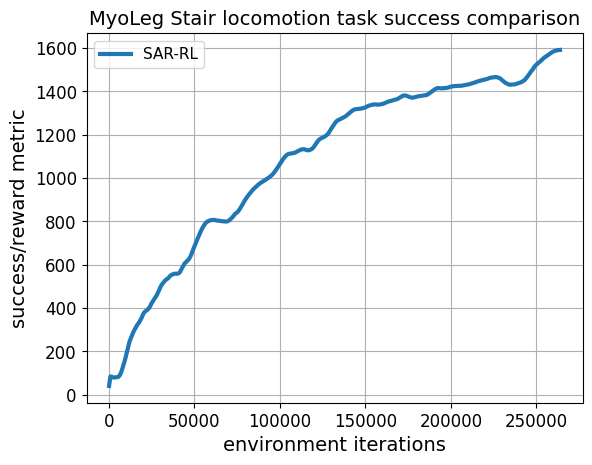

In [ ]:
new_terrian = 'Stair'
plot_results(experiment='locomotion', terrain='Stair', smoothing=10)#new_terrain)

# Full training example 2: SAR x physiological manipulation

Now, we turn to using synergies for manipulation rather than locomotion. In this example:
- a policy is trained on an eight-object reorientation task, `Reorient8-v0`.
- after training, we collect muscle activation data from policy rollouts
- variance accounted for (VAF) by N synergies is computed. Here, we select N where VAF > 0.8.
- SAR is computed at this VAF threshold.
- SAR is used to train on a 100-object reorientation task, `Reorient100-v0`.

<strong>Note: we also provide the option of using pretrained policies/representations at some of the above steps. Run the code below depending on your preferences.</strong>

# Step 2.1

First, we acquire our synergistic action representation. We provide two options for this:

<strong>Option A: Get SAR from scratch (i.e., train on `Reorient8` as play period → get muscle activations → compute SAR).</strong>

<strong>Option B: Use the precomputed SAR.</strong>

## Option 2.1.A: Get SAR from scratch

In [ ]:
# a policy is trained on an eight-object reorientation task, Reorient8-v0
train(env_name='myoHandReorient8-v0', policy_name='play_period', timesteps=1e6, seed='0')

In [ ]:
# after training, we collect muscle activation data from policy rollouts
muscle_data = get_activations(name='play_period', env_name='myoHandReorient8-v0', seed='0', episodes=10)

In [ ]:
# VAF by N synergies is computed. Here, N is selected where VAF > 0.8
syn_dict = find_synergies(muscle_data, plot=True)
print("VAF by N synergies:", syn_dict)

In [ ]:
# make and load a video of the trained policy

video_name = 'play_period_vid'
get_vid(name='play_period', env_name='myoHandReorient8-v0', seed='0', episodes=10, video_name=video_name)
show_video(f"{video_name}.mp4")

In [ ]:
# SAR is computed at this VAF threshold
ica,pca,normalizer = compute_SAR(muscle_data, 20, save=False)

## Option 2.1.B: Use precomputed SAR

In [ ]:
# RUN THIS CELL TO USE PRECOMPUTED SAR
ica,pca,normalizer = load_manipulation_SAR()

# Step 2.2: Train on Reorient100 with synergies (SAR-RL)

In [ ]:
# SAR is used to train on a 100-object reorientation task, Reorient100-v0
SAR_RL(env_name='myoHandReorient100-v0', policy_name='SAR-RL', timesteps=1.5e6, 
       seed='0', ica=ica, pca=pca, normalizer=normalizer, phi=.66)

In [ ]:
# make and load a video of the trained policy

video_name = 'SAR_vid'

get_vid(name='SAR-RL', env_name='myoHandReorient100-v0', seed='0', episodes=10, video_name=video_name, 
        determ=True, pca=pca, ica=ica, normalizer=normalizer, phi=.66, is_sar=True, syn_nosyn=True)
show_video(f"{video_name}.mp4")

# Step 2.3 (optional): Train on Reorient100 with end-to-end RL (RL-E2E)

We can compare the performance of (A) pretraining for 1M steps on `Reorient8-v0`, getting SAR, and training with SAR-RL on `Reorient100-v0` for 2M steps with (B) training for 3M steps using end-to-end RL ('RL-E2E').

In [ ]:
train(env_name='myoHandReorient100-v0', policy_name='RL-E2E', timesteps=2.5e6, seed='0')

In [ ]:
# make and load a video of the trained policy

video_name = 'RL+E2E_vid'
get_vid('RL-E2E', 'myoHandReorient100-v0', '0', determ=False, episodes=10, video_name=video_name)
show_video(f"{video_name}.mp4")

# Step 2.4: Plot results

For convenience, a function is defined to automatically plot the results of these runs (ensure the names and seeds are preserved).

In [ ]:
plot_results(experiment='manipulation')

# Step 2.5 (optional): zero-shot testing manipulation policies on new unseen objects

We can optionally test these manipulation policies on unseen objects to determine their generalizability. Here, we implement two test
environments.

1. ReorientID-v0—1000 unseen objects generated by sampling from the same dimensions as those for the Reorient100-v0 set. Intuitively, this environment contains new objects with the same kind of shapes as those seen in the training set.

2. ReorientOOD-v0—1000 unseen objects generated by sampling from different dimensions as those for the Reorient100-v0 set. Intuitively, this environment contains new objects with different kinds of shapes as those seen in the training set.

In [ ]:
def zeroshot_test(name, test_env_name, env_name='myoHandReorient100-v0', seed='0', determ=True, ica=None, 
                  pca=None, normalizer=None, phi=.66, episodes=500, is_sar=False, syn_nosyn=False):
    """
    Check zero-shot performance of policies on the test environments.
    
    name: str; name of the policy to test
    env_name: str; name of gym env the policy to test was trained on (Reorient100-v0).
    seed: str; seed of the policy to test
    test_env_name: str; name of the desired test env
    ica: if testing SAR-RL, the ICA object
    pca: if testing SAR-RL, the PCA object
    normalizer: if testing SAR-RL, the normalizer object
    phi: float; blend parameter between synergistic and nonsynergistic activations
    episodes: int; number of episodes to run on the test environment
    """
    if is_sar:
        if syn_nosyn:
            env = SynNoSynWrapper(gym.make(test_env_name), ica, pca, normalizer, phi)
        else:
            # env = SynergyWrapper(gym.make(test_env_name), ica, pca, normalizer, phi)
            env = SynergyWrapper(gym.make(test_env_name), ica, pca, normalizer)
    else:
        env = gym.make(test_env_name)
    env.reset()

    model = SAC.load(f'{name}_model_{env_name}_{seed}')
    vec = VecNormalize.load(f'{name}_env_{env_name}_{seed}', DummyVecEnv([lambda: env]))
    solved = []
    for i,_ in enumerate(range(episodes)):
        is_solved = []
        env.reset()
        done = False
        while not done:
            o = env.get_obs()
            o = vec.normalize_obs(o)
            a, __ = model.predict(o, deterministic=determ)
            next_o, r, done, *_, info = env.step(a)
            is_solved.append(info['solved'])
        
        if sum(is_solved) > 0:
            solved.append(1)
        else:
            solved.append(0)

    env.close()
    return np.mean(solved)

In [ ]:
# zero-shot testing RL-E2E policy

name = 'RL-E2E'

e2e_id = zeroshot_test(name, 'myoHandReorientID-v0')

e2e_ood = zeroshot_test(name, 'myoHandReorientOOD-v0')

In [ ]:
# zero-shot testing SAR-RL policy

name = 'SAR-RL'

sar_id = zeroshot_test(name, 'myoHandReorientID-v0', ica=ica, pca=pca, 
                       normalizer=normalizer, is_sar=True, syn_nosyn=True)

sar_ood = zeroshot_test(name, 'myoHandReorientOOD-v0', ica=ica, pca=pca, 
                        normalizer=normalizer, is_sar=True, syn_nosyn=True)

We can visualize these zero-shot generalization results by running the cell below.

In [ ]:
# plot results
    
zeroshot = {"SAR-RL": [sar_id,sar_ood],
            "RL-E2E": [e2e_id,e2e_ood]}

fig, ax = plt.subplots()
plot_zeroshot(ax, zeroshot)
fig.set_size_inches(6, 5)
plt.show()